# Utilities

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from skimage import transform
from skimage.transform import rotate, AffineTransform,warp
from skimage import util
from skimage.filters import gaussian
from sklearn import preprocessing
import numpy as np



import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


In [38]:
def showImage(image):
    plt.imshow(image, cmap = matplotlib.cm.binary, interpolation='nearest')
    plt.axis('off')
    plt.show()

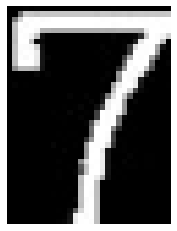

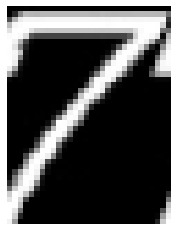

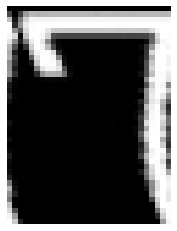

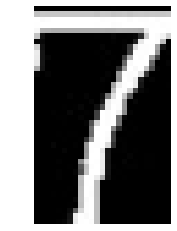

In [39]:

image = cv2.imread("dataSet/trainData/7/7C0.jpg", cv2.COLOR_BGR2GRAY)
showImage(image)

img = image

# image = rotate(img, angle=-45,cval=1); 
# showImage(image)
# image = rotate(img, angle=45,cval=1); 
# showImage(image)
image = transform.warp(img, AffineTransform(shear=-0.4), order=1, preserve_range=True, mode='wrap');
showImage(image)
image = transform.warp(img, AffineTransform(shear=0.4), order=1, preserve_range=True, mode='wrap'); 
showImage(image)
# #----------------------------------------------------------------
image = img.copy();
image[:, 0:5] = 0
showImage(image)



In [40]:
# Image Augmentation, referncee: https://www.codespeedy.com/image-augmentation-using-skimage-in-python/

import random 


def augmentImage(img):
    # original image
    augmentedImages=[img.flatten()]
    augmentedImages.append(img.flatten()) # add the image multiple times
    augmentedImages.append(img.flatten()) # add the image multiple times
    # rotation by i
    for i in range(1, 19):
        randomNum = random.randint(-5,5)
        image = rotate(img, angle=i*10 + randomNum, cval=1); augmentedImages.append(image.flatten())
        image = rotate(img, angle=-i*10 + randomNum, cval=1); augmentedImages.append(image.flatten())
    # Shearing
    image = transform.warp(img, AffineTransform(shear=-0.4), order=1, preserve_range=True, mode='wrap'); augmentedImages.append(image.flatten())
    image = transform.warp(img, AffineTransform(shear=0.4), order=1, preserve_range=True, mode='wrap'); augmentedImages.append(image.flatten())
    # Cropping by 7
    image = img.copy(); image[:, 23:] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[:, 0:7] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[0:7,:] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[33:, :] = 0; augmentedImages.append(image.flatten())
    # Cropping by 10
    image = img.copy(); image[:, 20:] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[:, 0:10] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[0:10,:] = 0; augmentedImages.append(image.flatten())
    image = img.copy(); image[30:, :] = 0; augmentedImages.append(image.flatten())
    # inverse
    image = 1 - img.copy(); augmentedImages.append(image.flatten())

    
    return augmentedImages
    
    


# Import and split the data

In [41]:
import os
trainData = []
trainLabels = []

dire="DataSet/trainData" 

classes = os.listdir(dire)
print(classes)

numClassesWithLimit = 0
LIMIT = 10000 # to have the same number of items in all classes
for innerDir in os.listdir(dire):
    count = 0
    for filename in os.listdir(dire+'/' +innerDir):
        # read image
        image = cv2.imread(dire+'/' + innerDir +'/' +filename, cv2.COLOR_BGR2GRAY)/255.0

        # augmentImage
        augmentedImages = augmentImage(image.copy())
        count +=  len(augmentedImages)

        # append images
        trainData+=augmentedImages
        trainLabels+=[innerDir] * len(augmentedImages)

        # to break the inner loop if the number of items in the class exceeded the LIMIT
        if (count >= LIMIT):
            numClassesWithLimit+=1
            print("Class", innerDir , "has", count, "items")
            break

print("Number of classes that have exceeded", LIMIT, "items is:", numClassesWithLimit, "out of", len(os.listdir(dire)))
print("trainData Size:", len(trainData), "and trainLabels size:", len(trainLabels))



['10', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'club', 'diamond', 'heart', 'J', 'K', 'Q', 'spade']
Class 10 has 10000 items
Class club has 10000 items
Class diamond has 10000 items
Class heart has 10000 items
Class spade has 10000 items
Number of classes that have exceeded 10000 items is: 5 out of 17
trainData Size: 144150 and trainLabels size: 144150


In [42]:
from sklearn.model_selection import train_test_split

# split the data
trainData, testData, trainLabels, testLabels = train_test_split(trainData, trainLabels, test_size = 0.1 , random_state=50)


# Trainning

In [43]:
model_KNN = KNeighborsClassifier(n_neighbors=17, weights='distance',n_jobs=-1) 
model_KNN.fit(trainData, trainLabels)

KNeighborsClassifier(n_jobs=-1, n_neighbors=17, weights='distance')

In [132]:
# from sklearn.svm import LinearSVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# model_SVC = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, max_iter=1e5))
# # model_SVC = svm.SVC(gamma=.001,C=100)
# model_SVC.fit(trainData, trainLabels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(max_iter=100000.0, random_state=0, tol=1e-05))])

# Save the model

In [83]:
from joblib import dump, load
# save the model
# dump(model_SVC, 'SVC_model.joblib') 
dump(model_KNN, 'KNN_model.joblib') 

# load the model
model_KNN = load('KNN_model.joblib')
model_SVC = load('SVC_model.joblib')

# model = model_KNN

# Evaluate the model

In [15]:
from sklearn.metrics import accuracy_score

# KNN
Labels_KNN_pred = model_KNN.predict(testData) 
print("KNN Model Accuarcy", accuracy_score(testLabels, Labels_KNN_pred)) # validate the model

KNN Model Accuarcy 0.9798433048433048


In [45]:
from sklearn.metrics import accuracy_score

# SVM
Labels_SVM_pred = model_SVC.predict(testData) # test -predict the test trainData-
print("SVM Model Accuarcy", accuracy_score(testLabels, Labels_SVM_pred)) # validate the model

SVM Model Accuarcy 0.32001387443635104


# Random TestCases

In [75]:
import random 

count  = 0
LIMIT = 10
for i in range(LIMIT):
    randomIndex = random.randint(0,len(testLabels))

    # prediction
    prediction = model_KNN.predict([testData[randomIndex]])
    probabilities = model_KNN.predict_proba([testData[randomIndex]])[0]
    classIndex =  np.where(model_KNN.classes_ == prediction)[0]
    print("Predicted", testLabels[randomIndex], "as", prediction[0],
         "With probability", probabilities[classIndex])
    #
    if (testLabels[randomIndex] == model_KNN.predict([testData[randomIndex]])[0]):
        count += 1
print(count+1, "Passed out of", LIMIT)


Predicted 7 as 7 With probability [1.]
Predicted 4 as 4 With probability [1.]
Predicted club as club With probability [1.]
Predicted 8 as 8 With probability [1.]
Predicted Q as Q With probability [1.]
Predicted 3 as 3 With probability [1.]
Predicted 8 as 8 With probability [1.]
Predicted spade as spade With probability [1.]
Predicted Q as Q With probability [1.]
Predicted A as A With probability [1.]
11 Passed out of 10


# Test Data

Number of test images 142
Predicted as J With probability [1.]


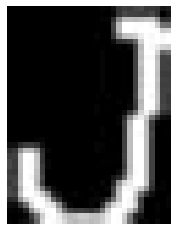

Predicted as 10 With probability [1.]


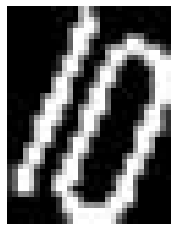

Failed to detect the symbol


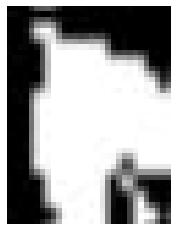

Predicted as J With probability [1.]


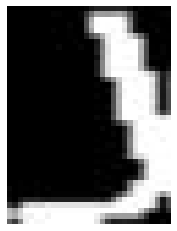

Predicted as club With probability [0.99999986]


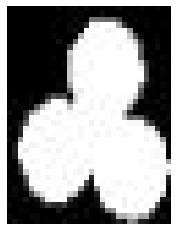

Predicted as 10 With probability [1.]


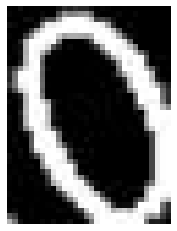

Predicted as heart With probability [1.]


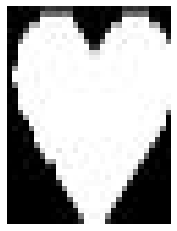

Predicted as J With probability [1.]


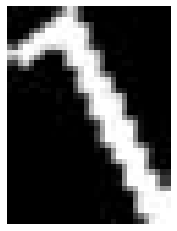

Predicted as heart With probability [0.99999955]


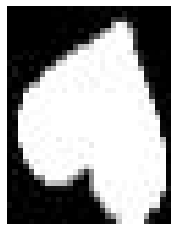

Predicted as diamond With probability [1.]


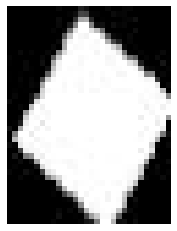

Predicted as heart With probability [0.99999998]


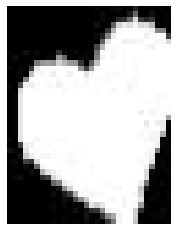

Predicted as heart With probability [0.99999958]


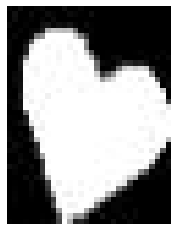

Predicted as A With probability [1.]


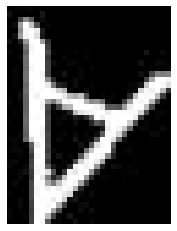

Failed to detect the symbol


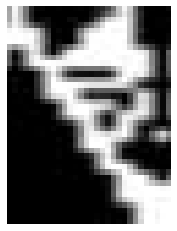

Predicted as A With probability [1.]


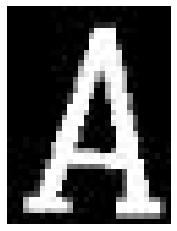

Predicted as A With probability [1.]


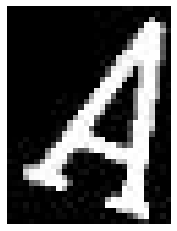

Predicted as A With probability [1.]


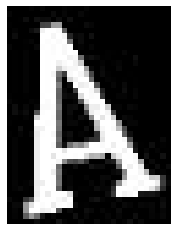

Predicted as diamond With probability [1.]


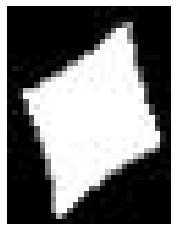

Predicted as club With probability [0.9999996]


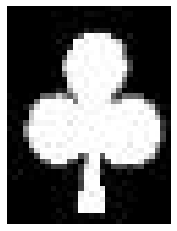

Predicted as heart With probability [0.99999954]


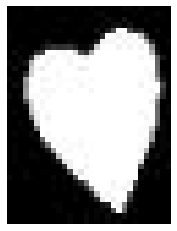

Predicted as A With probability [1.]


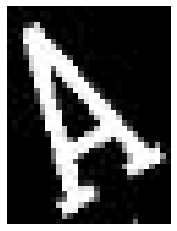

Predicted as spade With probability [0.99999932]


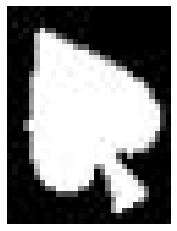

Predicted as diamond With probability [1.]


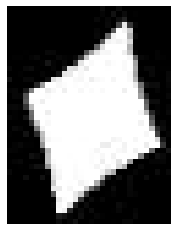

Predicted as spade With probability [1.]


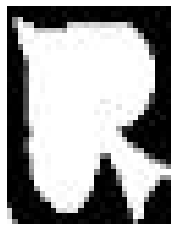

Failed to detect the symbol


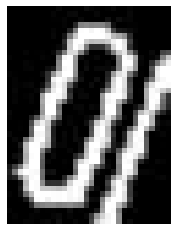

Predicted as spade With probability [1.]


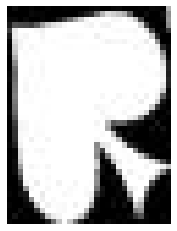

Predicted as spade With probability [1.]


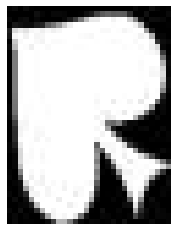

Predicted as spade With probability [1.]


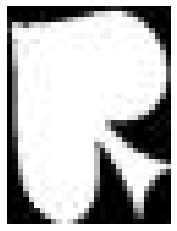

Predicted as spade With probability [1.]


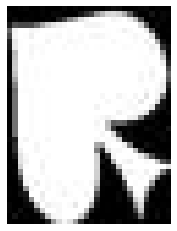

Failed to detect the symbol


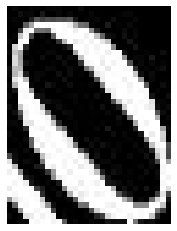

Failed to detect the symbol


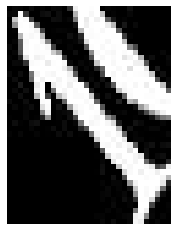

Predicted as spade With probability [1.]


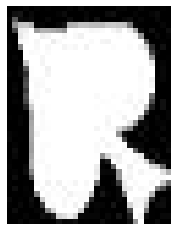

Predicted as spade With probability [1.]


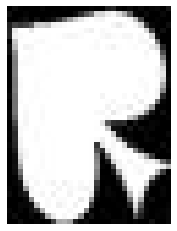

Predicted as A With probability [0.99999977]


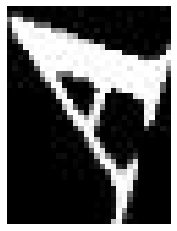

Predicted as spade With probability [1.]


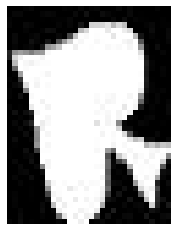

Predicted as Q With probability [1.]


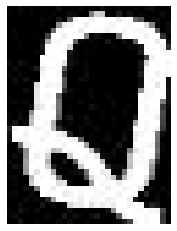

Failed to detect the symbol


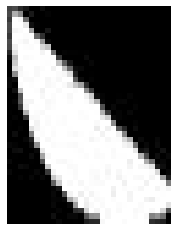

Predicted as 9 With probability [0.99999983]


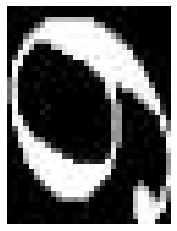

Predicted as heart With probability [0.9999999]


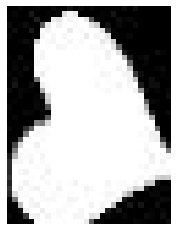

Predicted as A With probability [0.99999968]


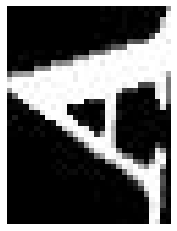

Predicted as heart With probability [1.]


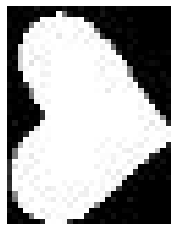

Failed to detect the symbol


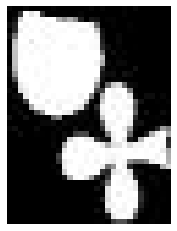

Predicted as 7 With probability [1.]


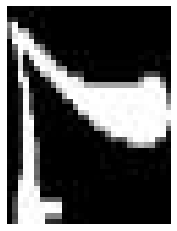

Failed to detect the symbol


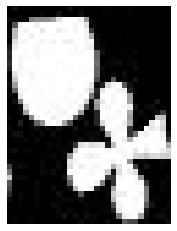

Failed to detect the symbol


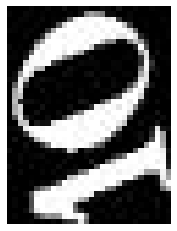

Failed to detect the symbol


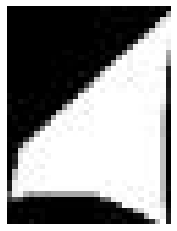

Predicted as J With probability [1.]


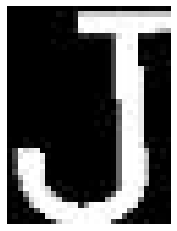

Failed to detect the symbol


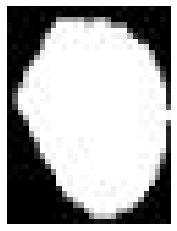

Failed to detect the symbol


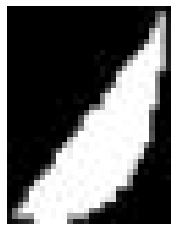

Predicted as K With probability [1.]


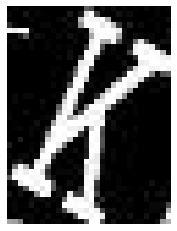

Predicted as heart With probability [1.]


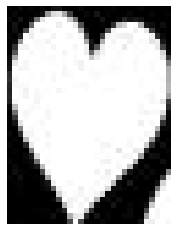

Predicted as heart With probability [1.]


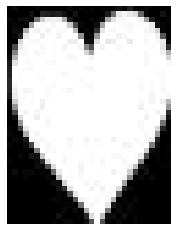

Predicted as heart With probability [1.]


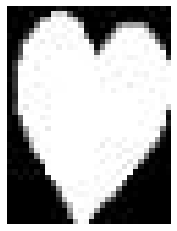

Failed to detect the symbol


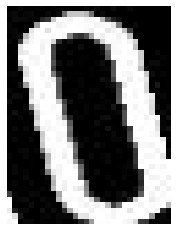

Predicted as Q With probability [1.]


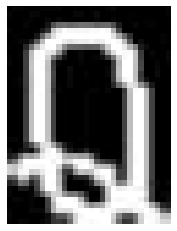

Predicted as heart With probability [1.]


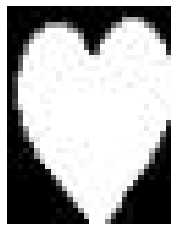

Predicted as heart With probability [1.]


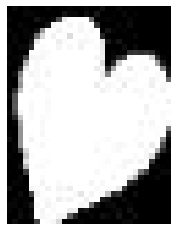

Predicted as heart With probability [1.]


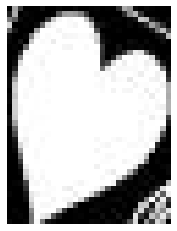

Predicted as heart With probability [1.]


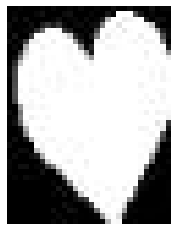

Predicted as 9 With probability [1.]


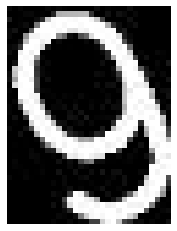

Predicted as heart With probability [1.]


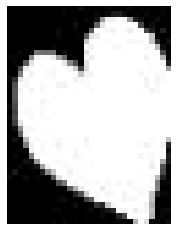

Failed to detect the symbol


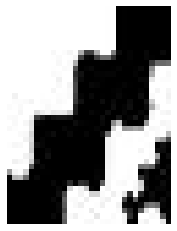

Predicted as heart With probability [0.99999978]


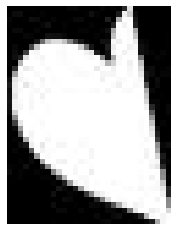

Predicted as heart With probability [0.9999999]


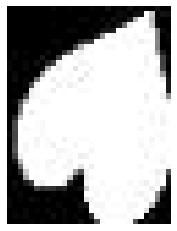

Predicted as K With probability [1.]


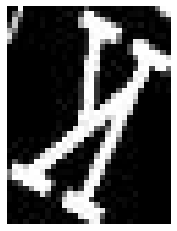

Predicted as spade With probability [0.99999995]


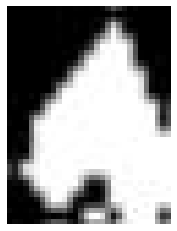

Predicted as 7 With probability [1.]


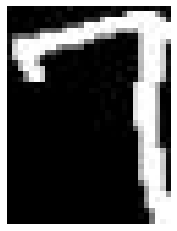

Predicted as heart With probability [1.]


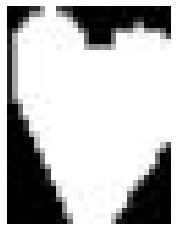

Failed to detect the symbol


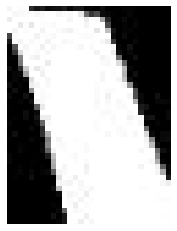

Predicted as 7 With probability [1.]


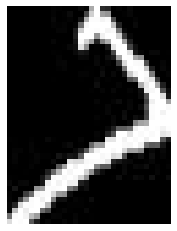

Predicted as club With probability [1.]


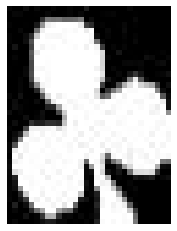

Predicted as spade With probability [0.99999983]


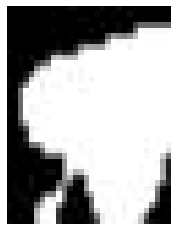

Predicted as spade With probability [1.]


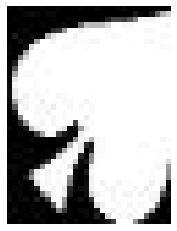

Failed to detect the symbol


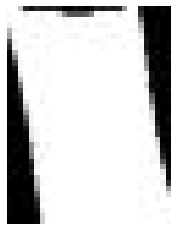

Predicted as spade With probability [1.]


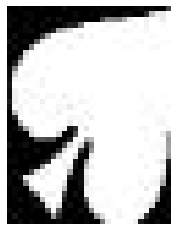

Predicted as 7 With probability [0.99999986]


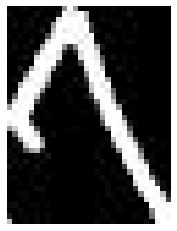

Predicted as spade With probability [0.99999993]


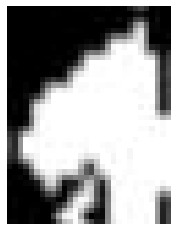

Predicted as spade With probability [1.]


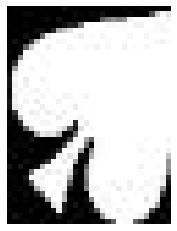

Predicted as spade With probability [1.]


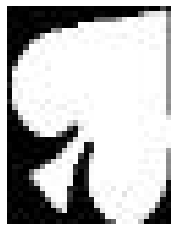

Failed to detect the symbol


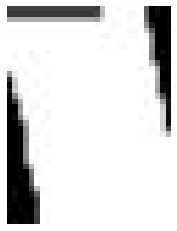

Failed to detect the symbol


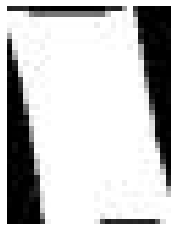

Predicted as spade With probability [1.]


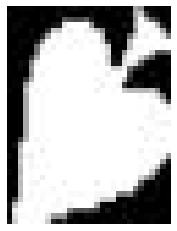

Failed to detect the symbol


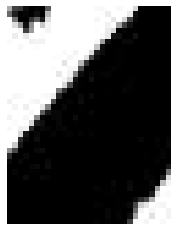

Predicted as 7 With probability [0.99999996]


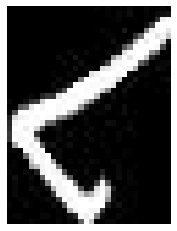

Predicted as A With probability [1.]


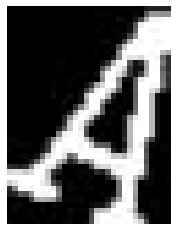

Predicted as spade With probability [0.99999962]


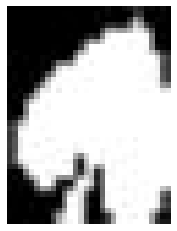

Predicted as heart With probability [1.]


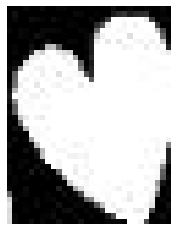

Predicted as spade With probability [0.99999982]


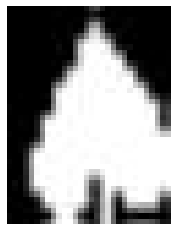

Predicted as 9 With probability [1.]


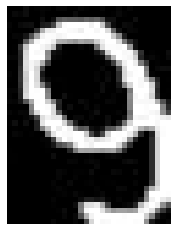

Predicted as heart With probability [0.99999941]


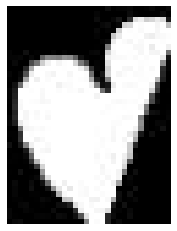

Predicted as heart With probability [1.]


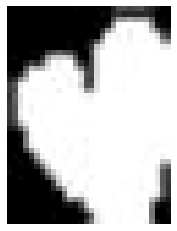

Failed to detect the symbol


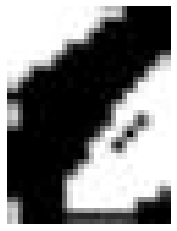

Predicted as spade With probability [0.99999979]


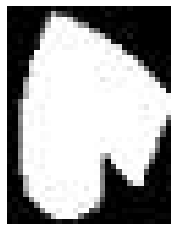

Predicted as spade With probability [0.9999995]


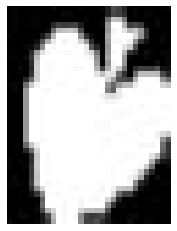

Predicted as A With probability [1.]


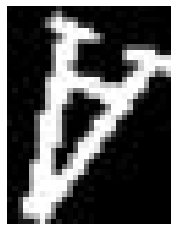

Predicted as A With probability [0.99999995]


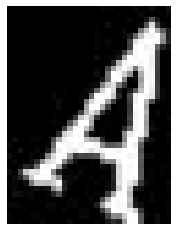

Predicted as A With probability [1.]


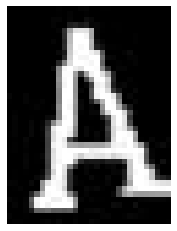

Predicted as diamond With probability [1.]


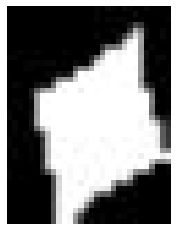

Predicted as K With probability [0.99999974]


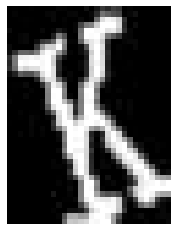

Predicted as club With probability [1.]


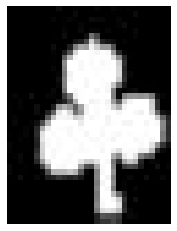

Failed to detect the symbol


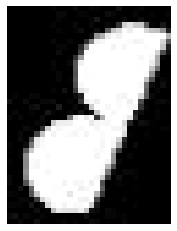

Predicted as diamond With probability [1.]


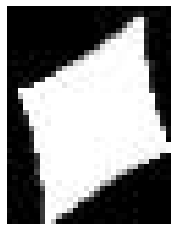

Predicted as diamond With probability [1.]


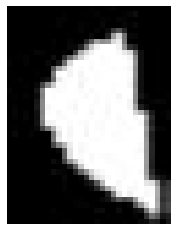

Predicted as diamond With probability [1.]


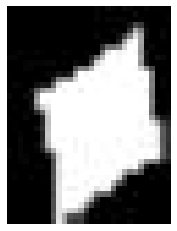

Predicted as A With probability [1.]


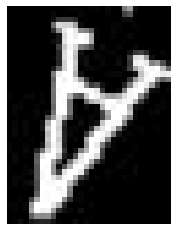

Predicted as 10 With probability [0.82948624]


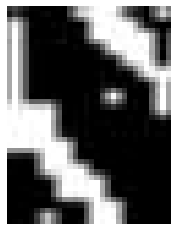

Predicted as 2 With probability [0.99999984]


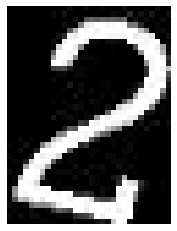

Predicted as 3 With probability [1.]


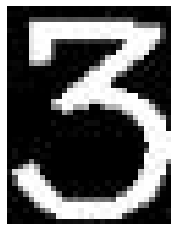

Predicted as A With probability [1.]


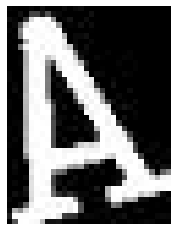

Predicted as spade With probability [1.]


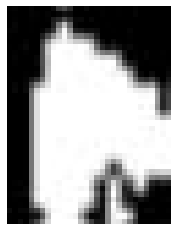

Predicted as spade With probability [1.]


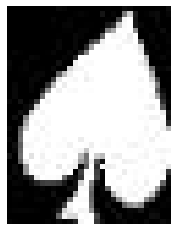

Predicted as club With probability [1.]


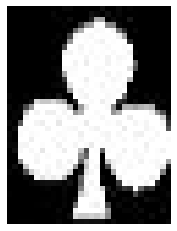

Predicted as heart With probability [1.]


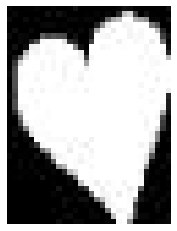

Predicted as spade With probability [1.]


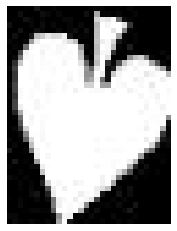

Predicted as 2 With probability [1.]


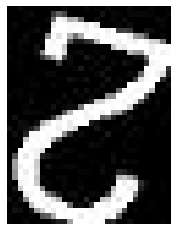

Predicted as 4 With probability [0.99999998]


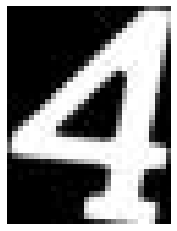

Predicted as 3 With probability [1.]


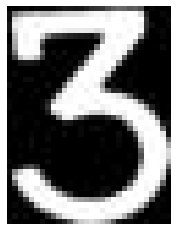

Predicted as 5 With probability [1.]


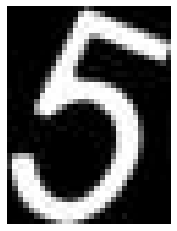

Predicted as 2 With probability [1.]


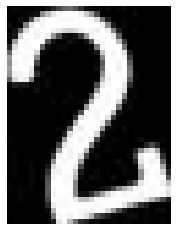

Predicted as spade With probability [0.89020408]


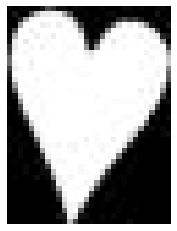

Failed to detect the symbol


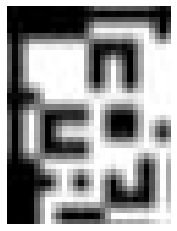

Predicted as spade With probability [1.]


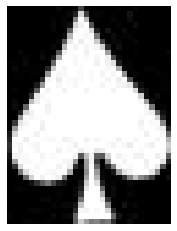

Predicted as club With probability [0.94314345]


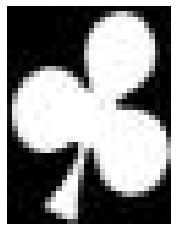

Predicted as A With probability [1.]


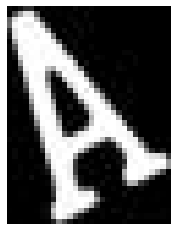

Predicted as diamond With probability [1.]


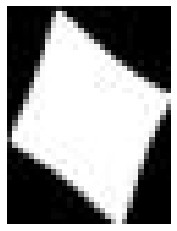

Predicted as 5 With probability [1.]


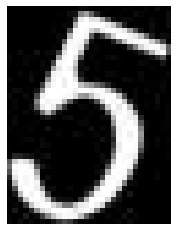

Predicted as spade With probability [1.]


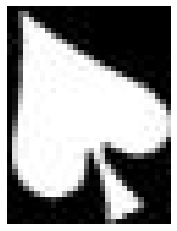

Predicted as club With probability [0.88529595]


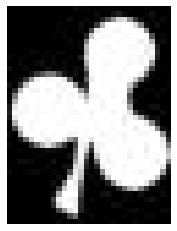

Predicted as club With probability [0.9406174]


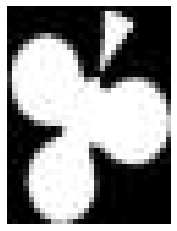

Failed to detect the symbol


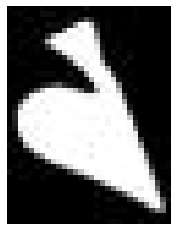

Predicted as club With probability [0.94000215]


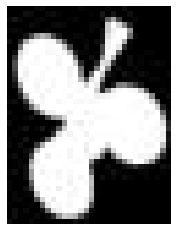

Predicted as A With probability [1.]


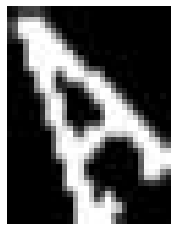

Predicted as 5 With probability [1.]


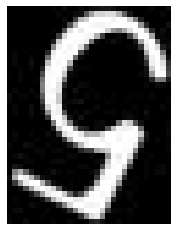

Predicted as A With probability [1.]


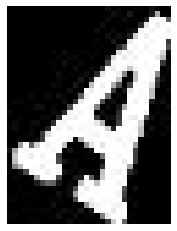

Predicted as K With probability [1.]


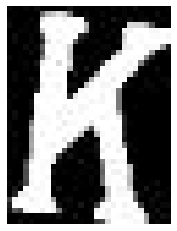

Failed to detect the symbol


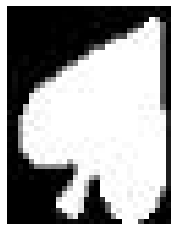

Predicted as Q With probability [1.]


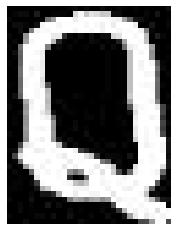

Predicted as heart With probability [0.94788888]


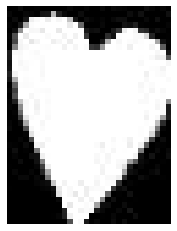

Predicted as J With probability [1.]


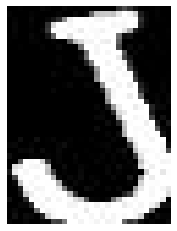

Predicted as K With probability [1.]


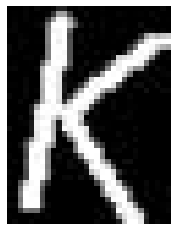

Predicted as Q With probability [1.]


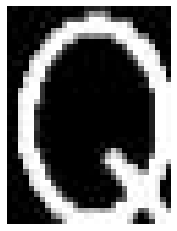

Predicted as A With probability [1.]


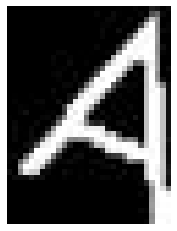

In [82]:
import os

dire="../Grouping/imgs/"
print("Number of test images", len(os.listdir(dire)))
for filename in os.listdir(dire):
    image = cv2.imread(dire+filename, cv2.COLOR_BGR2GRAY)/255.0
    # print(image.shape)
    prediction = model_KNN.predict([image.flatten()])
    probabilities = model_KNN.predict_proba([image.flatten()])[0]
    classIndex =  np.where(model_KNN.classes_ == prediction)[0]
    if (probabilities[classIndex] < 0.8):
        print("Failed to detect the symbol")
    else:
        print("Predicted as", prediction[0],
            "With probability", probabilities[classIndex])
    showImage(image)